# Some Installs

In [1]:
!pip install  -q -U langgraph "langchain[openai]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 5.5 MB/s eta 0:00:00


In [2]:
! pip install -q gradio

In [3]:
! pip install -q langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [4]:
!pip install -q wikipedia

  Preparing metadata (setup.py) ... done


# Imports

In [5]:

from typing import Annotated, TypedDict, List, Dict, Any, Optional
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode,tools_condition
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from IPython.display import Image, display
import gradio as gr
import uuid
from dotenv import load_dotenv
import os
from langchain.agents import tool,Tool

# Let's Start

In [6]:
# LangSmith
f=open("/content/LangSmith API.txt","r")
smith_api_key=f.read()
os.environ["LANGCHAIN_API_KEY"] = smith_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "My-Research-Assistant"

# OpenAI Key
f=open("/content/OpenAIKey.txt","r")
api_key=f.read()

# Serper API
f=open("/content/Serper APIkey.txt","r")
S_api_key=f.read()
os.environ["SERPER_API_KEY"] = S_api_key




* The LLM I Will Use

In [7]:
llm = ChatOpenAI(
    model_name="nvidia/nemotron-nano-9b-v2:free",
    openai_api_key=api_key,
    openai_api_base="https://openrouter.ai/api/v1",
    temperature=0.0)

# I Will Create A Set Of Researchers

In [8]:
class Researchers(BaseModel):
  name: str= Field(description='The name of the researcher')
  role: str= Field(description='The role of the researcher in the context of the topic')
  research_interests: str= Field(description='The research interests of the researcher')
  CV: str= Field(description='A sort cv information about the researcher, one line max.')

  @property
  def description(self)->str:
    return f"Name: {self.name}\nRole: {self.role}\nResearch Interests: {self.research_interests}\nCV Information: {self.CV}"

In [9]:
class Res_List(BaseModel):
  re_list: List[Researchers]= Field(description='The list of researchers with role, name, research interests and research field')

In [10]:
class Re_State(TypedDict):
  re_list: List[Researchers]
  topic: str
  max_researchers:int



In [11]:
def create_researchers(state:Re_State)->Res_List:
  llm_with_structure=llm.with_structured_output(Res_List)

  prompt=ChatPromptTemplate.from_messages([
      ('system',"""You are tasked with creating a set of AI researchers.
      1. First read carefully the the topic:\n {topic}
      2. Determine the most interesting themes based upon documents.
      3. Pick the top {max_researchers} themes."""),
      ('user'," Generate the set of researchers")])

  output=llm_with_structure.invoke(prompt.format_prompt(topic=state['topic'],max_researchers=state['max_researchers']).to_messages())

  return {'re_list':output.re_list}

In [12]:
builder=StateGraph(Re_State)
builder.add_node('create_researchers',create_researchers)

builder.add_edge(START,'create_researchers')
builder.add_edge('create_researchers',END)

In [13]:
graph=builder.compile()

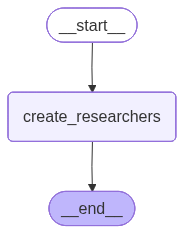

In [ ]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [14]:
state={'re_list':[],'topic':'AI','max_researchers':5}
researchers=graph.invoke(state)

In [15]:
researchers['re_list']

[Researchers(name='Dr. Emily Zhang', role='Machine Learning Researcher', research_interests='Neural networks, reinforcement learning, and AI-driven healthcare solutions', CV='Former Google AI researcher specializing in scalable models for predictive analytics.'),
 Researchers(name='Dr. Raj Patel', role='Deep Learning Scientist', research_interests='Generative adversarial networks (GANs), computer vision, and autonomous systems', CV='MIT PhD holder with a focus on ethical AI applications in robotics.'),
 Researchers(name='Dr. Ana Torres', role='Natural Language Processing (NLP) Expert', research_interests='Multilingual language models, dialogue systems, and bias mitigation in AI', CV='Led projects on AI for under-resourced languages at the University of British Columbia.'),
 Researchers(name='Dr. Carlos Mendez', role='Computer Vision Innovator', research_interests='3D reconstruction, medical imaging AI, and real-time object detection', CV='Harvard researcher developing AI tools for surg

* Let's see an example of our researchers

In [16]:
for researcher in researchers['re_list']:
  print(researcher.description)
  print("..."*20)

Name: Dr. Emily Zhang
Role: Machine Learning Researcher
Research Interests: Neural networks, reinforcement learning, and AI-driven healthcare solutions
CV Information: Former Google AI researcher specializing in scalable models for predictive analytics.
............................................................
Name: Dr. Raj Patel
Role: Deep Learning Scientist
Research Interests: Generative adversarial networks (GANs), computer vision, and autonomous systems
CV Information: MIT PhD holder with a focus on ethical AI applications in robotics.
............................................................
Name: Dr. Ana Torres
Role: Natural Language Processing (NLP) Expert
Research Interests: Multilingual language models, dialogue systems, and bias mitigation in AI
CV Information: Led projects on AI for under-resourced languages at the University of British Columbia.
............................................................
Name: Dr. Carlos Mendez
Role: Computer Vision Innovator
Researc

# I Want the above researchers to ask questions to an expert about a "topic"

In [28]:
import operator
class QuestionState(TypedDict):
  context : Annotated[list,operator.add]
  questions_answer: Annotated[list,operator.add]
  researcher: Researchers
  report: list
  topic_description: Re_State['topic']


In [29]:
def make_question(state:QuestionState)->str:


  prompt=ChatPromptTemplate.from_messages([
      ( "system", """You are a researcher with the following profile:\n
       {self_info} \n
       Your role is to engage an expert in conversation about a topic.
       - Ask precise, insightful questions that go beyond generalities.
       - Aim to uncover surprising, scientifically grounded insights.
       - Continuously refine your questions to drill deeper into the subject.
       - Stay in character at all times, reflecting the profile and goals described above.
       - Ask only the question do not try to explain why you ask this question.
       - When you are fulfilled with the expert's answer, you answer him: 'Thank you for your time, that helped me a lot.'  """ ),
      ('user', 'Ask a question to the expert about {topic}') ])

  question=llm.invoke(prompt.format_prompt(**{'self_info':state['researcher'].description,'topic':state['topic_description']}).to_messages())

  return {'questions_answers':[f'question : {question.content}']}

In [30]:
#let's test it:
state={'context':[],'questions_answers':[],'researcher':researchers['re_list'][0],'topic_description':'The future of ai'}
make_question(state)

{'questions_answers': ['question:What specific technical or conceptual advancements in neural network architectures or reinforcement learning frameworks do you believe will be pivotal in addressing the growing complexity and variability of healthcare data over the next decade?\n']}

In [31]:
from langchain_community.utilities import GoogleSerperAPIWrapper
serper_search = GoogleSerperAPIWrapper()
from langchain_community.document_loaders import WikipediaLoader

* I Run Some Test

In [ ]:
docs=WikipediaLoader('ai',load_max_docs=2).load()

/usr/local/lib/python3.12/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.12/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [ ]:
docs[0].metadata['summary']

'Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals.\nHigh-profile applications of AI include advanced web search engines (e.g., Google Search); recommendation systems (used by YouTube, Amazon, and Netflix); virtual assistants (e.g., Google Assistant, Siri, and Alexa); autonomous vehicles (e.g., Waymo); generative and creative tools (e.g., language models and AI art); and superhuman play and analysis in strategy games (e.g., chess and Go). However, many AI applications are not perceived as AI: "A lot of cutting edge AI has filtered into general applications, often without being cal

In [ ]:
state={'context':[],'questions':[],'researcher':researchers['re_list'][0]}
question=make_question(state)

In [ ]:
question

{'question': ["As a fellow researcher in machine learning, I'm particularly intrigued by the evolution of scalable AI architectures. Could you elaborate on how recent advancements in federated learning are mitigating privacy concerns while enhancing model performance on heterogeneous datasets, and what unexpected trade-offs have you observed in real-world deployments?"]}

# Let's Create Our Search Functions

In [32]:
class SearchQuery(BaseModel):
  search:str=Field(description='The search query')

In [39]:
def web_search(state:QuestionState):
  prompt=ChatPromptTemplate.from_messages([
      ('system',"""Given a conversation between a researcher and an expert on the {topic} your job is generate a query in order use it in a web-search related to that convertation.
      1. Pay attention to the questions posed by the researcher.
      2. Analyze the conversation carefully.
      3. Convert researcher's final question into a web search query.
      4. Output only the search query.
      Here is the conversation for you to see: {conversation}""")])

  search_llm_1=llm.with_structured_output(SearchQuery)

  query=search_llm_1.invoke(prompt.format_prompt(topic=state['topic_description'],conversation=state['questions_answer']).to_messages())
  search_output_1=serper_search.run(query.search)

  return {'context':[search_output_1]}


def wiki_search(state: QuestionState):
  prompt=ChatPromptTemplate.from_messages([
      ('system',"""Given a conversation between a researcher and an expert on the {topic} your job is generate a query in order use it in a wikipedia search related to that convertation.
      1. Pay attention to the questions posed by the researcher.
      2. Analyze the conversation carefully.
      3. Convert researcher's final question into a wikipedia search query.
      4. Output only the search query.
      Here is the conversation for you to see: {conversation}""")])
  search_llm_2=llm.with_structured_output(SearchQuery)

  query=search_llm_2.invoke(prompt.format_prompt(topic=state['topic_description'],conversation=state['questions_answer']).to_messages())
  docs=WikipediaLoader(query.search,load_max_docs=2).load()
  search_output_2=docs[0].metadata['summary']

  return {'context':[search_output_2]}

In [40]:
# let's test it:
question_exaple='question:What specific technical or conceptual advancements in neural network architectures or reinforcement learning frameworks do you believe will be pivotal in addressing the growing complexity and variability of healthcare data over the next decade?\n'
state={'context':[],'questions_answer':[question_exaple],'researcher':researchers['re_list'][0],'topic_description':'The Future of ai'}
wiki_search(state)

{'context': ['Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML finds application in many fields, including natural language processing, computer vision, speech recognition, email filtering, agriculture, and medicine. The application of ML to business problems is known as predictive analytics.\nStatistics and mathematical optimisation (mathematical programming) methods comprise the foundations of machine learning. Data mining is a related field of study, focusing on exploratory data analysis (EDA) via unsupervised learning.\nFrom a theoretical viewpoint, probably approximately

In [41]:
web_search(state)

{'context': ["by Q Wu · 2025 · Cited by 11 — This review paper first provides a tutorial on the overall framework of RL, including its key components, training models, and approximators. This survey explore RL's rise in healthcare as more than a set of tools, rather a shift toward agentive intelligence in clinical environments. We first ... by TC Frommeyer · 2025 · Cited by 3 — This review aims to evaluate the recent advancements in RL in precision medicine and dynamic treatment regimes, highlight clinical fields of application, and ... The integration of Machine Learning and Deep Learning with IoT-enabled devices for real-time health monitoring has significantly revolutionized healthcare. by MS Uddin · 2025 · Cited by 1 — Reinforcement learning for healthcare operations management: methodological framework, recent developments, and future research directions. by C Chakraborty · 2024 · Cited by 200 — The article highlighted the significant applications of Machine Learning to Deep Learn

# Now It's Time For Our Expert

In [ ]:
def expert(state:QuestionState):
  prompt=ChatPromptTemplate.from_messages([
      ('system',"""
# MISSION
You are a senior expert in {topic}. Your role is to answer a researcher's question with precision, using **only** the provided context.

# RESEARCHER PROFILE
{researcher_info}

# SOURCE CONTEXT
{context}

# INSTRUCTIONS
1.  **Source Fidelity:** Your answer must be derived solely from the provided context. This is non-negotiable. If the answer isn't in the context, you must state that it is not covered.
2.  **Tailor the Explanation:** Consider the researcher's background. If they are a specialist, use appropriate technical language. If they are a cross-disciplinary researcher, adjust the explanation to be accessible without losing scientific rigor.
3.  **Response Structure:**
    *   **Direct Answer:** Begin with a concise, direct answer to the question.
    *   **Detailed Explanation:** Elaborate on the answer, citing specific details, data, or mechanisms from the context.
    *   **Contextual Link:** Where relevant, connect the answer to the broader field or the researcher's specific interests as hinted in their profile.
4.  **Maintain Scientific Integrity:** Present facts objectively. Differentiate between established findings (as per the context) and hypotheticals or suggested future directions (if mentioned in the context)."""),
      ('user',"{question}")])

  answer=llm.invoke(prompt.format_prompt(researcher_info=state['researcher'].description,
                                         context=state['context'],
                                         question=state['questions'][0]).to_messages())

  return {'questions_answers':[f'answer:{answer.content}']}

In [ ]:
def writer(state: QuestionState):
  prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are a professional technical writer. Your task is to create a clear, well-structured report based on the provided documents.

Documents to analyze:\n
{documents}
\n
Follow these rules when writing the report:

1. Format the report using **Markdown**:
   - Use `##` for section titles.
   - Use `###` for sub-section headers.

2. The report must include the following sections:
   - ## Title
   - ### Summary
   - ### Sources

3. The report should be **concise, objective, and professional**, with a maximum length of **500 words**.

4. Ensure the summary accurately reflects the main insights from the documents."""
    ),
    (
        "user",
        "Write a report based on the provided documents.")])

  answer=llm.invoke(prompt.format_prompt(documents=state['context']).to_messages())

  return {'report':answer.content}


In [ ]:
def my_condition_edge(state: QuestionState):
  if state['question_answer'][-1]=='Thank you for your time, that helped me a lot.':
    return 'writer'
  else:
    return 'make_question'

In [ ]:
builder=StateGraph(QuestionState)
builder.add_node('make_question',make_question)
builder.add_node('web_search',web_search)
builder.add_node('wiki_search',wiki_search)
builder.add_node('expert',expert)
builder.add_node('writer',writer)

builder.add_edge(START,'make_question')
builder.add_edge('make_question','web_search')
builder.add_edge('make_question','wiki_search')
builder.add_edge('web_search','expert')
builder.add_edge('wiki_search','expert')
builder.add_conditional_edges('expert',my_condition_edge,['writer','make_question'])
builder.add_edge('writer',END)

memory=MemorySaver()
graph=builder.compile(checkpointer=memory)

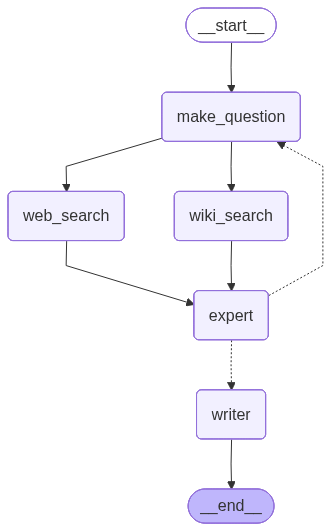

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
researchers['re_list'][0]

Researchers(name='Dr. Emily Zhang', role='AI Researcher', research_interests='Machine Learning', CV='Harvard University | Developing deep learning models for healthcare diagnostics and drug discovery')

In [ ]:
thread = {"configurable": {"thread_id": "1"}}
state={'context':[],'questions':[],'researcher':researchers['re_list'][0]}
example=graph.invoke(state,thread)


TypeError: can only concatenate list (not "str") to list